# Final model

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt

SCRIPTS_FILEPATH = "./../scripts/"
sys.path.append(SCRIPTS_FILEPATH)

from linear_model_base import RidgeRegression
from data_cleaner import Data_Cleaner
from proj1_helpers import *
from compute import compute_leaderboard_score

TRAIN_SET_FILEPATH = "../data/train.csv"
TEST_SET_FILEPATH = "../data/test.csv"
RESULTS_FILEPATH = "../results/predictions.csv"

In [15]:
#80/20 train test split to verify predictions before upload
data = Data_Cleaner(DATA_FILEPATH)

#replace with 1, due to log scaling 
data._fill_with_NaN()
data.fix_mass_MMC()
data.replace_with_one()

#find columns with multiscale input (max greater than 100)
log_columns = np.max(data.tX, axis=0)>100
#log(x+1) of columns with multiscale data, to ensure no x <= 0
data.tX[:,log_columns] = np.log(data.tX[:,log_columns]+1)

#generate poly features and interaction features
data.build_polynomial(2)
data.build_interactions()

tX_train, tX_test, y_train, y_test = data.split_data(80)

data_train = Data_Cleaner()
data_train.tX = tX_train
data_train.y = y_train

data_test = Data_Cleaner()
data_test.tX = tX_test
data_test.y = y_test

data_test.treat_outliers(1.5,92.5)
data_train.treat_outliers(1.5,92.5)

minimum, maximum = data_train.getMinMax()
data_train.standardize()

data_test.tX = (data_test.tX - minimum) / (maximum - minimum)

In [3]:
Model = RidgeRegression(data_train)
search_space = np.logspace(-15, -5, 15)
    
rmse_te = []
rmse_tr = []

for lambda_ in search_space:
        
    tr, te = Model.cross_validation(5, lambda_=lambda_)
    rmse_te.append(te)
    rmse_tr.append(tr)
        
    print("lambda {}".format(lambda_))  

lambda 1e-15
lambda 5.179474679231202e-15
lambda 2.6826957952797274e-14
lambda 1.389495494373136e-13
lambda 7.196856730011528e-13
lambda 3.727593720314938e-12
lambda 1.9306977288832457e-11
lambda 1e-10
lambda 5.179474679231223e-10
lambda 2.6826957952797275e-09
lambda 1.3894954943731388e-08
lambda 7.196856730011529e-08
lambda 3.727593720314938e-07
lambda 1.9306977288832536e-06
lambda 1e-05


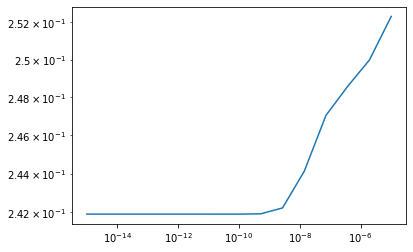

In [4]:
plt.loglog(np.logspace(-15, -5, 15),rmse_te)

In [5]:
best_lambda = search_space[np.where(rmse_te==np.min(rmse_te))]
best_lambda

array([1.e-10])

In [6]:
best_lambda = 5.17947468e-10

In [7]:
Model = RidgeRegression(data_test)
weights = Model._run(lambda_ = best_lambda)

y_pred = predict_labels(weights, data_test.tX)

In [9]:
compute_leaderboard_score(data_test.y,y_pred)

0.84552

In [12]:
#generate predictions
data_upload = Data_Cleaner(TEST_SET_FILEPATH)
data_upload._fill_with_NaN()
data_upload.fix_mass_MMC()
data_upload.replace_with_one()
log_columns = np.max(data_upload.tX, axis=0)>100
data_upload.tX[:,log_columns] = np.log(data_upload.tX[:,log_columns]+1)

#generate poly features and interaction features
data_upload.build_polynomial(2)
data_upload.build_interactions()
data_upload.treat_outliers(1.5,92.5)
#Standardize ?--------------------------------------------------------------------------
data_upload.tX = (data_upload.tX - minimum) / (maximum - minimum)

In [16]:
Model = RidgeRegression(data_train)
weights = Model._run(lambda_ = best_lambda)
y_pred = predict_labels(weights, data_upload.tX)

In [17]:
create_csv_submission(data_upload.ids, y_pred,RESULTS_FILEPATH)